In [1]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.visualize import extract_torsion_angles
from glycontact.learning import create_dataset, SweetNetMixtureModel, SweetNetHalfMixtureModel, train_model

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sh: cd-hit: command not found
sh: cd-hit-est: command not found
sh: diamond: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mmseqs: command not found
sh: mash: command not found
sh: foldseek: command not found
sh: TMalign: command not found


In [2]:
if not os.path.exists("conformer_split_final.pkl"):
    train, test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((train, test), f)
else:
    with open("conformer_split_final.pkl", "rb") as f:
        train, test = pickle.load(f)

In [3]:
model = SweetNetHalfMixtureModel(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim)

In [4]:
metrics = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=100,
)

Epoch 0/99
----------
train Loss: 8.0373 Phi: 0.9895 Psi: 1.3241 SASA: 222.6698 Flex: 2.0125
val Loss: 8.1370 Phi: 1.0360 Psi: 1.1890 SASA: 221.4354 Flex: 2.2213

Epoch 1/99
----------
train Loss: 6.7910 Phi: 0.5452 Psi: 1.0287 SASA: 221.6947 Flex: 1.5221
val Loss: 6.8535 Phi: 0.4944 Psi: 0.9654 SASA: 220.4022 Flex: 1.7203

Epoch 2/99
----------
train Loss: 6.1981 Phi: 0.2809 Psi: 0.9408 SASA: 220.7501 Flex: 1.2971
val Loss: 6.4847 Phi: 0.2824 Psi: 0.9438 SASA: 219.4313 Flex: 1.6014

Epoch 3/99
----------
train Loss: 5.9825 Phi: 0.2221 Psi: 0.8658 SASA: 219.8824 Flex: 1.2299
val Loss: 6.3501 Phi: 0.2485 Psi: 0.8414 SASA: 218.3758 Flex: 1.6206

Epoch 4/99
----------
train Loss: 5.8707 Phi: 0.2077 Psi: 0.8200 SASA: 219.0407 Flex: 1.1922
val Loss: 6.2516 Phi: 0.2704 Psi: 0.8269 SASA: 217.8606 Flex: 1.5233

Epoch 5/99
----------
train Loss: 5.8023 Phi: 0.1831 Psi: 0.8111 SASA: 218.1410 Flex: 1.1725
val Loss: 6.2326 Phi: 0.2770 Psi: 0.8416 SASA: 216.2226 Flex: 1.5103

Epoch 6/99
----------


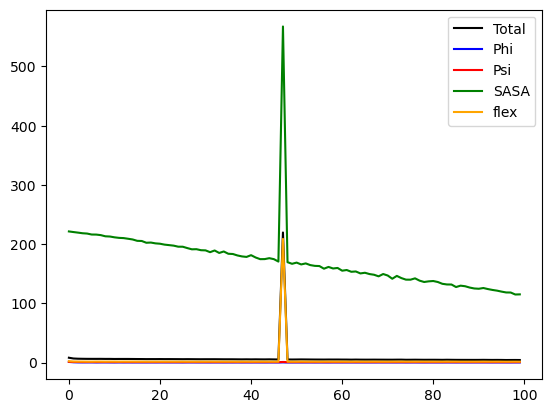

In [5]:
# plt.plot(metrics["train"]["loss"], label="total", c="black")
# plt.plot(metrics["train"]["phi_loss"], label="phi", c="blue")
# plt.plot(metrics["train"]["psi_loss"], label="phi", c="red")
# plt.plot(metrics["train"]["sasa_loss"], label="SASA", c="green")
# plt.plot(metrics["train"]["flex_loss"], label="flex", c="orange")

plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

# plt.yscale("log")
plt.legend()

plt.show()

In [13]:
def sample_angle(weights, mus, kappas):
    idx = np.random.choice(len(weights), p=weights)
    mu = (mus[idx] * np.pi / 180.0) % (2 * np.pi)
    if mu > np.pi:
        mu -= 2 * np.pi
    angle_sample = torch.distributions.von_mises.VonMises(mu, kappas[idx] + 1e-10).sample()
    angle_sample = angle_sample * 180.0 / np.pi
    return angle_sample


def sample_value(weights, mus, sigmas):
    idx = np.random.choice(len(weights), p=weights)
    return torch.distributions.normal.Normal(mus[idx], sigmas[idx]).sample()


def sample_from_model(model, structures, count=10):
    """
    Sample from the model using the provided structures
    Args:
        model: The trained model
        structures: List of structure graphs
    Returns:
        List of sampled angles
    """
    model.eval()
    sampled_structures = []
    with torch.no_grad():
        for i, (data, graph) in enumerate(structures):
            print(f"\r{i + 1} / {len(structures)}", end="")
            for _ in range(count):
                # weights_logits_von_mises, mus_von_mises, kappas_von_mises, weights_logits_gaussian, mus_gaussian, sigmas_gaussian = model(data.x.to("cuda"), data.edge_index.to("cuda"))
                weights_logits_von_mises, mus_von_mises, kappas_von_mises, sasa_pred, flex_pred = model(data.x.to("cuda"), data.edge_index.to("cuda"))
                weights_von_mises = torch.nn.functional.softmax(weights_logits_von_mises, dim=2).cpu().numpy()
                # weights_gaussian = torch.nn.functional.softmax(weights_logits_gaussian, dim=2).cpu().numpy()

                G = copy.deepcopy(graph)
                for n, node in enumerate(G.nodes):
                    # phi_sample = sample_angle(weights_von_mises[n, 0], mus_von_mises[n, 0], kappas_von_mises[n, 0])
                    # idx = np.random.choice(len(weights_von_mises[n, 0]), p=weights_von_mises[n, 0])
                    # mu = (mus_von_mises[n, 0, idx] * np.pi / 180.0) % (2 * np.pi)
                    # if mu > np.pi:
                    #     mu -= 2 * np.pi
                    # phi_samples = torch.distributions.von_mises.VonMises(mu, kappas_von_mises[n, 0, idx]).sample()
                    # phi_samples = phi_samples * 180.0 / np.pi
                    
                    # psi_sample = sample_angle(weights_von_mises[n, 1], mus_von_mises[n, 1], kappas_von_mises[n, 1])
                    # idx = np.random.choice(len(weights_von_mises[n, 1]), p=weights_von_mises[n, 1])
                    # mu = (mus_von_mises[n, 1, idx] * np.pi / 180.0) % (2 * np.pi)
                    # if mu > np.pi:
                    #     mu -= 2 * np.pi
                    # psi_samples = torch.distributions.von_mises.VonMises(mu, kappas_von_mises[n, 1, idx]).sample()
                    # psi_samples = psi_samples * 180.0 / np.pi
                    
                    # sasa_samples = sample_value(weights_gaussian[n, 0], mus_gaussian[n, 0], sigmas_gaussian[n, 0])
                    # idx = np.random.choice(len(weights_gaussian[n, 0]), p=weights_gaussian[n, 0])
                    # sasa_samples = torch.distributions.normal.Normal(mus_gaussian[n, 0, idx], sigmas_gaussian[n, 0, idx]).sample()
                    
                    # flex_samples = sample_value(weights_gaussian[n, 1], mus_gaussian[n, 1], sigmas_gaussian[n, 1])
                    # idx = np.random.choice(len(weights_gaussian[n, 1]), p=weights_gaussian[n, 1])
                    # flex_samples = torch.distributions.normal.Normal(mus_gaussian[n, 1, idx], sigmas_gaussian[n, 1, idx]).sample()
                    
                    if "phi_angle" in G.nodes[node]:
                        G.nodes[node]["phi_angle"] = sample_angle(weights_von_mises[n, 0], mus_von_mises[n, 0], kappas_von_mises[n, 0]).item()
                        G.nodes[node]["psi_angle"] = sample_angle(weights_von_mises[n, 1], mus_von_mises[n, 1], kappas_von_mises[n, 1]).item()
                    elif "SASA" in G.nodes[node]:
                        # G.nodes[node]["SASA"] = sample_value(weights_gaussian[n, 0], mus_gaussian[n, 0], sigmas_gaussian[n, 0]).item()
                        # G.nodes[node]["flexibility"] = sample_value(weights_gaussian[n, 1], mus_gaussian[n, 1], sigmas_gaussian[n, 1]).item()
                        G.nodes[node]["SASA"] = sasa_pred[n].item()
                        G.nodes[node]["flexibility"] = flex_pred[n].item()
                sampled_structures.append(G)
    return sampled_structures


sample_from_model(model, [x], count=1)[0].nodes(data=True)
# samples = sample_from_model(model, test)

1 / 1

NodeDataView({0: {'labels': 2060, 'string_labels': 'Neu5Ac', 'Monosaccharide': 'Neu5Ac(a2-3)', 'SASA': 192.48165893554688, 'flexibility': 2.3173296451568604, 'Q': 0.438, 'theta': 16.74, 'conformation': '2C5'}, 1: {'labels': 2414, 'string_labels': 'a2-3', 'phi_angle': 42.45976257324219, 'psi_angle': -78.11412811279297, 'omega_angle': None}, 2: {'labels': 591, 'string_labels': 'Gal', 'Monosaccharide': 'Gal(a1-4)', 'SASA': 87.00178527832031, 'flexibility': 0.802916407585144, 'Q': 0.452, 'theta': 8.16, 'conformation': '4C1'}, 3: {'labels': 2403, 'string_labels': 'a1-4', 'phi_angle': -116.58333587646484, 'psi_angle': -103.77434539794922, 'omega_angle': None}, 4: {'labels': 591, 'string_labels': 'Gal', 'Monosaccharide': 'Gal(b1-4)', 'SASA': 84.75578308105469, 'flexibility': 0.6615616679191589, 'Q': 0.474, 'theta': 15.01, 'conformation': '4C1'}, 5: {'labels': 2433, 'string_labels': 'b1-4', 'phi_angle': 48.54623794555664, 'psi_angle': 126.48577880859375, 'omega_angle': None}, 6: {'labels': 913

In [7]:
x = list(sorted([x for x in test if "Neu5Ac(a2-3)Gal" in x[0].iupac], key=lambda x: len(x[0].iupac)))[10]

In [8]:
x[1].nodes(data=True)

NodeDataView({0: {'labels': 2060, 'string_labels': 'Neu5Ac', 'Monosaccharide': 'Neu5Ac(a2-3)', 'SASA': 383.7589611367167, 'flexibility': 1.310176419383025, 'Q': 0.438, 'theta': 16.74, 'conformation': '2C5'}, 1: {'labels': 2414, 'string_labels': 'a2-3', 'phi_angle': -93.15, 'psi_angle': -145.43, 'omega_angle': None}, 2: {'labels': 591, 'string_labels': 'Gal', 'Monosaccharide': 'Gal(a1-4)', 'SASA': 166.94530275559072, 'flexibility': 0.6249022533839811, 'Q': 0.452, 'theta': 8.16, 'conformation': '4C1'}, 3: {'labels': 2403, 'string_labels': 'a1-4', 'phi_angle': -88.18, 'psi_angle': -147.57, 'omega_angle': None}, 4: {'labels': 591, 'string_labels': 'Gal', 'Monosaccharide': 'Gal(b1-4)', 'SASA': 168.42466404299907, 'flexibility': 0.39578605060380284, 'Q': 0.474, 'theta': 15.01, 'conformation': '4C1'}, 5: {'labels': 2433, 'string_labels': 'b1-4', 'phi_angle': 62.73, 'psi_angle': 142.53, 'omega_angle': None}, 6: {'labels': 913, 'string_labels': 'Glc', 'Monosaccharide': 'Glc(b1-1)', 'SASA': 203.

In [9]:
def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')  # , edgecolor='white')
        # ax.tricontour(phi_angles, psi_angles, z, levels=5, linewidths=0.5, colors='k', alpha=0.4)
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

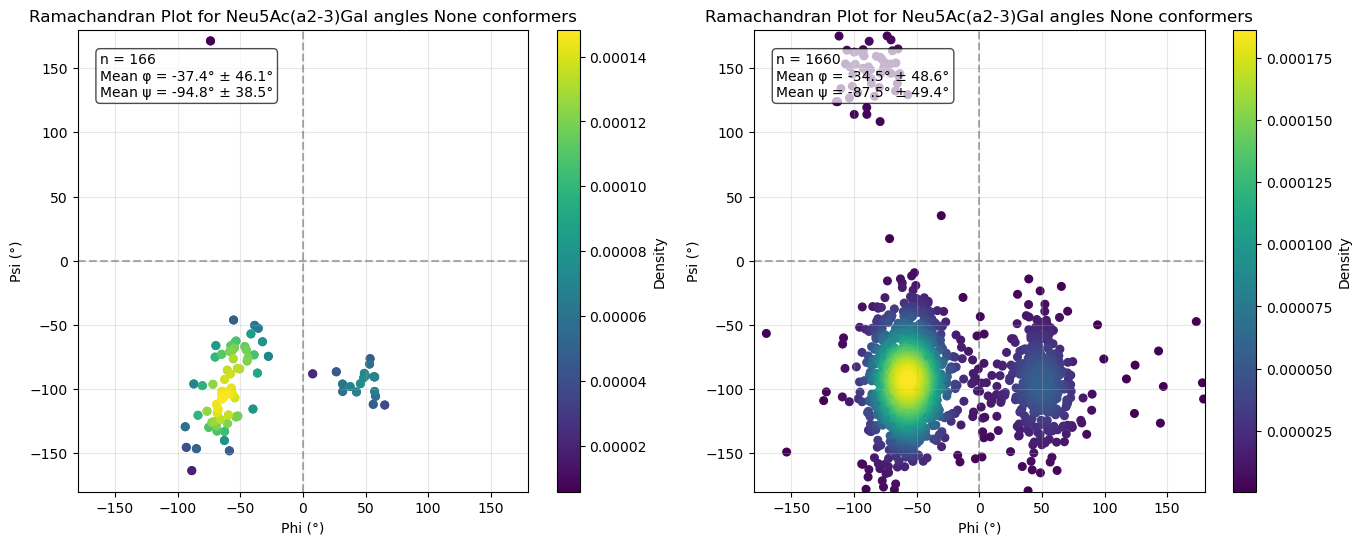

In [10]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=samples, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

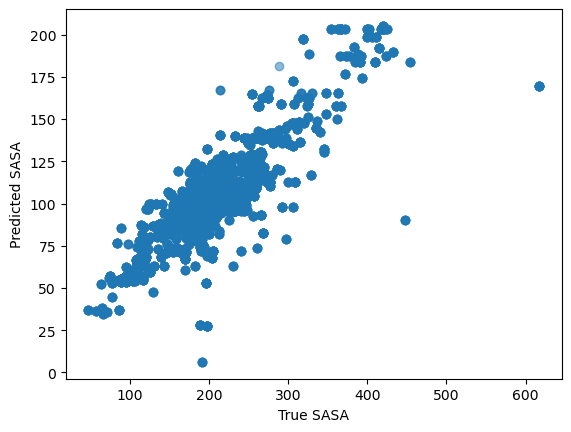

In [11]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, alpha=0.5)
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

plot_value_distributions(
    [t[1] for t in test], 
    [samples[x] for x in range(0, len(samples), 10)],
    value_name="SASA",
)

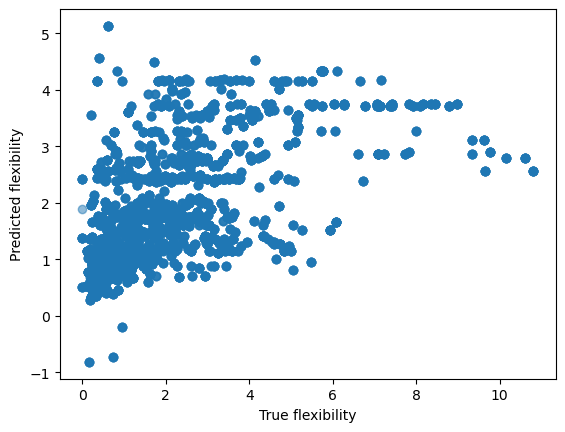

In [12]:
plot_value_distributions(
    [t[1] for t in test], 
    [samples[x] for x in range(0, len(samples), 10)],
    value_name="flexibility",
)